<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Каменев Михаил Сергеевич.

# <center>Калибровка вероятностей в ML</center>

## Калибровка? Какая калибровка?

Приветствую тебя, дорогой читатель! Прости меня за этот неформальный стиль, надеюсь, он тебя не бесит :p Не хотелось бы сразу давать тучу теоретических выкладок, доказывающих, что некоторые алгоритмы в методе predict_proba возвращают вовсе не proba, а что-то непонятное. Поэтому, рассмотрим одну очень простую, но чрезвычайно полезную для понимания, задачу из теории связи. Давай мы с тобой разберемся в том, как работает демодулятор!

Если ты далёк от радиофизики, ничего страшного, я тоже от неё далёк :D. Но я уверен, что у тебя есть телефон, а значит ты каждый день демодулируешь. Когда базовая станция передает на твой телефон сигнал, он представляется в виде каких-то точек на комплексной плоскости. Например, следующий набор точек соответствует созвездию QPSK.

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

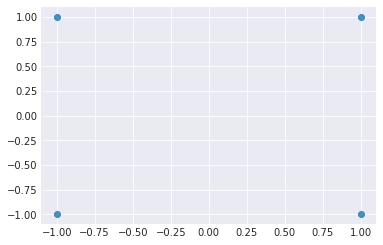

In [2]:
qpsk_points = np.array([[-1,-1],[-1,1], [1,-1], [1,1]])
sns.set_style("darkgrid")
sns.regplot(x=qpsk_points[:,0], y=qpsk_points[:,1],fit_reg=False);

Соответственно, базовая станция выбирает одну из этих точек и передает на телефон. Всё было бы хорошо, если бы не шум в канале связи. К сожалению, телефон получает не точку $x$, а $y = x + \mathcal{N}(0, \sigma ^ 2)$. Выглядит это как-то так:

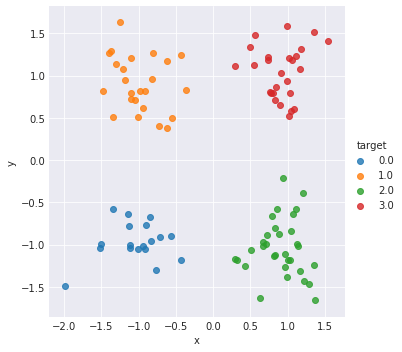

In [3]:
np.random.seed(4444)
points_count = 100

transmitted_points = np.random.randint(2,size=(points_count, 2))
classes = 2 * transmitted_points[:,0] + transmitted_points[:,1]
transmitted_points = transmitted_points * 2 - 1
noise = np.random.multivariate_normal([0,0], [[0.1,0],[0,0.1]], size=points_count)
received_points = transmitted_points + noise

data = pd.DataFrame(data=np.hstack((received_points, classes.reshape(-1,1))), columns=['x','y', 'target'])
sns.lmplot(x='x', y='y', data=data, hue='target', fit_reg=False);

Поэтому демодулятор вычисляет вероятность того, что базовая станция передала одну из возможных точек при условии принятой точки $y$: $P(x = x' | y)$. Естественно, вычисляется это по формуле Байесса:

$$ P(x = x' | y) = \frac{P(y | x = x')P(x')}{P(y)}$$

Вероятности по всем возможным четырем значениям в дальнейшем будут нормироваться, чтобы их сумма была равна единице. При этом дробь $\frac{P(x')}{P(y)}$ будет принимать одинаковые значения для всех четырех значений (предполагаем, что P(x') = 1/4 для всех $x'$, то есть все точки равновероятны). Поэтому, её можно не вычислять: она всё равно уйдет после нормировки (слава нормировке!). Из всей этой неясной писанины следует одно: достаточно посчитать $P(y | x = x')$ для всех возможных значений $x'$ и отнормировать эти значения так, чтобы они в сумме давали 1. Тем самым мы получим честные значения условных вероятностей!

Сгенерим выборку из 100000 точек и посчитаем честные вероятности способом, описанным выше. Затем обучим логистическую регрессию, добавив полиномиальные признаки. Из четвертой лекции мы знаем, что без них логистическая регрессия в данной задаче будет работать очень плохо. Затем сравним честные вероятности с теми, что вернёт метод predict_proba класса LogisticRegression (Disclaimer: всё будет отлично!). И в конце сделаем всё тоже самое, но для случайного леса (Disclaimer: всё будет очень плохо).

In [4]:
%%time
# Генерируем зашумленные точки
np.random.seed(4444)
points_count = 100000

transmitted_points = np.random.randint(2,size=(points_count, 2))
classes = 2 * transmitted_points[:,0] + transmitted_points[:,1]
transmitted_points = transmitted_points * 2 - 1
noise = np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=points_count)
received_points = transmitted_points + noise

# Считаем условные вероятности
probs = np.zeros((points_count, 4))
all_possible_points = np.array([[-1, -1], [-1, 1], [1, -1], [1,1]])
for row_idx, received_point  in enumerate(received_points):
    for col_idx, point in enumerate(all_possible_points):
        probs[row_idx, col_idx] = multivariate_normal.pdf(received_point, mean=point, cov=[[1,0],[0,1]])


# Делаем нормировочку
probs_norm = probs / np.repeat(np.sum(probs, axis=1).reshape(-1,1),4,1)

CPU times: user 41.7 s, sys: 55.1 ms, total: 41.8 s
Wall time: 41.5 s


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
# Добавляем полиномиальные признаки и делим нашу выборку на обучающую и тестовую
X = np.hstack((received_points, received_points ** 2, (received_points[:,0] * received_points[:,1]).reshape(-1,1)))
y = classes
X_train, X_test, y_train, y_test, probs_train, probs_test = train_test_split(X,y,probs_norm, test_size=0.3,shuffle=True, random_state=4444)

In [7]:
# Обучаем логистическую регрессию
logit = LogisticRegression(random_state=4444, multi_class='multinomial', solver='lbfgs')
logit.fit(X_train, y_train)
probs_logit = logit.predict_proba(X_test)

In [8]:
# смотрим на ошибку
np.mean(np.abs(probs_logit - probs_test))

0.001803402543577795

Видно, что в среднем логистическая регрессия ошибается на 0.002. На мой взгял, очень даже неплохой результат. Посмотрим теперь на случайный лес!

In [9]:
random_forest = RandomForestClassifier(random_state=4444, n_estimators=100)
random_forest.fit(X_train[:,[0,1]], y_train) # отбрасываем полиномиальные признаки
probs_forest = random_forest.predict_proba(X_test[:,[0,1]])

In [10]:
np.mean(np.abs(probs_forest - probs_test))

0.07908128038398034

0.08. Как минимум, гораздо больше чем 0.002. На всякий случай, посмотрим на accuracy_score для обоих алгоритмов.

In [11]:
print(accuracy_score(y_test, np.argmax(probs_logit, axis=1)))
print(accuracy_score(y_test, np.argmax(probs_forest, axis=1)))

0.7089333333333333
0.6675333333333333


Как вариант, можно попробовать случайный вес с деревьями максимальной глубины 2. Точность в этом случае станет одинаковой, но с вероятностями всё будет чуть хуже.

Дорогой читатель, тут мы подходим к главной причине написания этого тьюториала: случайный лес, svm, байессовские методы косячат с вероятностями. Сильно косячат. Поэтому было предложенно два метода (Platt's scaling и Isotonic Regression), чтобы как-то это дело подправить. И еще:

<center>
<img src="../../img/andrew_ng_dts.jpg">

## Некоторые вводные

Начнем c того, что в документации sklearn есть отличная <a href='http://scikit-learn.org/stable/modules/calibration.html'>статья</a> на рассматриваемую тему. Для меня её было немножко тяжеловато читать и в ней совсем не рассказывается о том, как работать с методами калибровки. Однако там есть очень красивые картинки, среди которых присутствуют кривые калибровки.

Предположим, что модель предсказывает вероятность принадлежности объекта к целевому классу в 0.5. Рассмотрим все объекты, которым модель предсказала вероятность в промежутке [0.49, 0.51]. Тогда среди рассматриваемых объектов, около половины должно принадлежать целевому классу (если алгоритм выдает честные вероятности, конечно).

Для начала, оставим в нашем примере только две точки: [1,1] и [-1,-1]. 

In [12]:
# Генерируем зашумленные точки
np.random.seed(4444)
points_count = 100000

transmitted_points = np.random.randint(2,size=(points_count, 1))
classes = transmitted_points[:,0]
transmitted_points = np.repeat(transmitted_points * 2 - 1,2,1)
noise = np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=points_count)
received_points = transmitted_points + noise

In [13]:
# Метод для построения кривой калибровки
def calibration_curve(y_pred, y_true):
    sorted_idx = np.argsort(y_pred)
    y_pred_sorted = y_pred[sorted_idx]
    y_true_sorted = y_true[sorted_idx]
    bins = np.linspace(0,1,11)
    bin_values = np.zeros((bins.size - 1, 2))
    for idx in range(1,bins.size):
        from_prob = bins[idx - 1]
        to_prob = bins[idx]
        positive_count = 0
        total_count = 0
        for prob, y in zip(y_pred_sorted,y_true_sorted):
            if prob >= from_prob:
                total_count += 1.
                if y == 1:
                    positive_count += 1.
            if prob > to_prob:
                break
        bin_values[idx - 1, :] = [(from_prob + to_prob) / 2, positive_count / total_count if total_count != 0 else 0]
    return bin_values


In [14]:
X = np.hstack((received_points, received_points ** 2, (received_points[:,0] * received_points[:,1]).reshape(-1,1)))
y = classes
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,shuffle=True, random_state=4444)

In [15]:
logit = LogisticRegression(random_state=4444)
logit.fit(X_train, y_train)
probs_logit = logit.predict_proba(X_test)[:,1]
random_forest = RandomForestClassifier(random_state=4444, n_estimators=100)
random_forest.fit(X_train[:,[0,1]], y_train) # отбрасываем полиномиальные признаки
probs_forest = random_forest.predict_proba(X_test[:,[0,1]])[:,1]

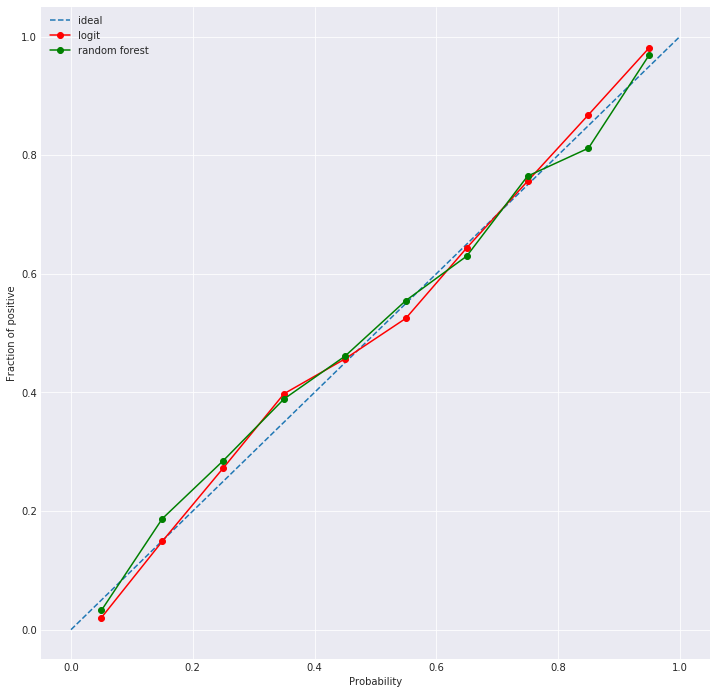

In [16]:
ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
#ax = plt.plot(x=ideal_curve, y=ideal_curve, ax=ax, linestyles='dashed')
#ax = plt.plot(x=bins[:,0], y=bins[:,1], ax=ax, color='red')
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
plt.legend(['ideal', 'logit', 'random forest'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

Чудеса! Может показаться, что всё хорошо и где-то в начале была допущена грубая ошибка. Но давайте, сначала, рассмотрим реальные данные. Например, датасет с информацией по оттоку клиентов.

In [17]:
# код сворован из тетрадки с четвертой лекции

data = pd.read_csv('../../data/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,shuffle=True, random_state=4444)

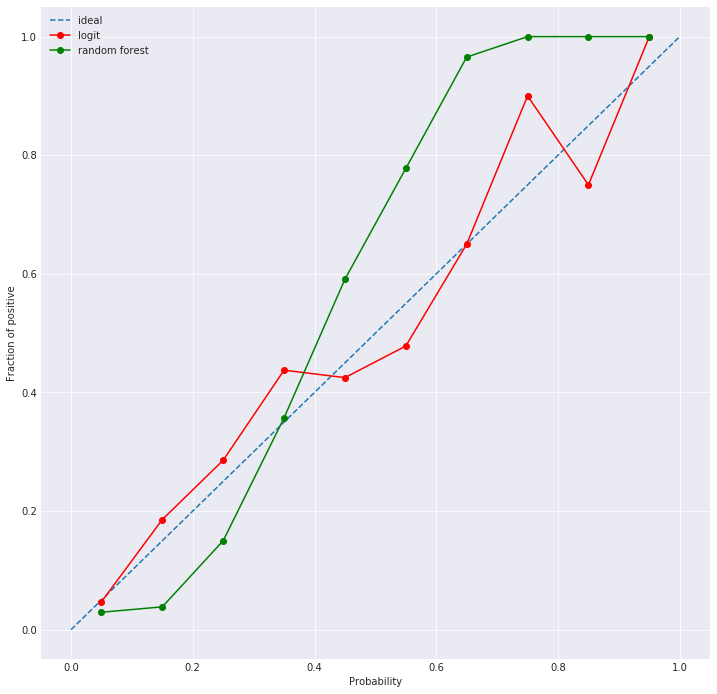

logit roc-auc score: 0.809298
random forest roc-auc score: 0.912807


In [18]:
logit = LogisticRegression(random_state=4444)
random_forest = RandomForestClassifier(random_state=4444, n_estimators=100)
logit.fit(X_train,y_train)
random_forest.fit(X_train, y_train)
probs_logit = logit.predict_proba(X_test)[:,1]
probs_forest = random_forest.predict_proba(X_test)[:,1]

ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
plt.legend(['ideal', 'logit', 'random forest'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

print('logit roc-auc score: %f' % roc_auc_score(y_test,probs_logit))
print('random forest roc-auc score: %f' % roc_auc_score(y_test,probs_forest))

Как известно, чудес не бывает =). Несмотря на то, что случайный лес по качеству оказался лучше логита, по вероятностям логит выглядит симпатичнее. Задача калибровки сводится к тому, чтобы приблизить хорошую модель, но с плохими вероятностями, к идеальной кривой. Тем самым мы не потеряем в качестве, а с другой стороны будем получать честные вероятности.

## Platt's scaling

Данный алгоритм был предложен в 1999 товарищем по фамилии Platt в <a href='http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639'> статье </a> Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods. Из названия видно, что алгоритм изначально был предложен для улучшения svm. Однако он работает для любой модели, в том числе и для случайного леса. 

Идея алгоритма проста до безобразия: 
- создаем отложенную выборку;
- обучаем модель на обучающей выборке;
- делаем предсказания на отложенной выборке;
- обучяем логистическую регрессию на этих предсказаниях;
- profit!

В статье есть маленькое уточнение для целевой переменной в четвертом пункте. Обычно метки класса равны -1 и 1. Однако Platt рассматривает значения $\frac{N_+ + 1}{N_+ + 2}$ и $\frac{1}{N_- + 2}$. В статье вывод этих формул отсутствует и, по крайней мере мне, не совсем понятно, почему рассматриваются именно такие значения.

Для наглядности, попробуем реализовать данный метод.

In [19]:
# 1) Создаем отложенную выборку
X_train_platt, X_valid_platt, y_train_platt, y_valid_platt = train_test_split(X_train,y_train, test_size=0.3,shuffle=True, random_state=4444)

In [20]:
# 2) Обучаем случайный лес
random_forest.fit(X_train_platt, y_train_platt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=4444, verbose=0,
            warm_start=False)

In [21]:
# 3) Делаем предсказание для отложенной выборки
probs_forest_valid = random_forest.predict_proba(X_valid_platt)[:,1]

In [22]:
# 4) Обучаем логистичекую регрессию на предсказаниях леса
# в идеале, тут бы применить scale из статьи, но тогда logit выбросит ошибку 
# так что, если строго, это не совсем platt scaling =)
logit_platt = LogisticRegression(random_state=4444)
logit_platt.fit(probs_forest_valid.reshape(-1,1), y_valid_platt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=4444, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
# 5) profit!
probs_forest_platt = logit_platt.predict_proba(random_forest.predict_proba(X_test)[:,1].reshape(-1,1))[:,1]

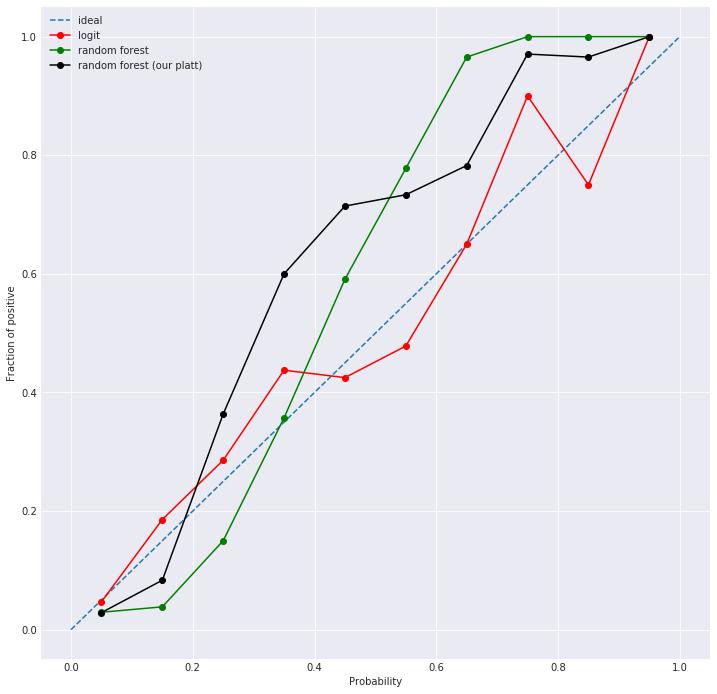

logit roc-auc score: 0.809298
random forest with platt roc-auc score: 0.912954


In [24]:
ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
forest_curve_platt = calibration_curve(probs_forest_platt, y_test)
plt.plot(forest_curve_platt[:,0], forest_curve_platt[:,1], 'o-',color='k')
plt.legend(['ideal', 'logit', 'random forest', 'random forest (our platt)'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

print('logit roc-auc score: %f' % roc_auc_score(y_test,probs_logit))
print('random forest with platt roc-auc score: %f' % roc_auc_score(y_test,probs_forest_platt))

Видно, что после калибровки (черная кривая) вероятности стали чуть лучше в сравнеии с "чистым" случайным лесом (зеленая кривая)

Известно, что изобретать велосипед не очень хорошо, поэтому воспользуемся реализованным в sklearn классом CalibratedClassifierCV. Его конструктор принимает на вход следующие параметры:

- base_estimator - модель, которую будем калибровать
- method - тут возможно два варианта: 'sigmoid' - это рассматриваемый platt scaling и 'isotonic' - это isotonic regression, к ней мы еще вернемся
- cv - параметры кросс-валидации. По умолчанию данные бьются на три фолда. Можно указать количество фолдов с помощью целого числа. Можно передать объект-генератор. Если коротко, то это обычный cv, как и во многих других моделях. Есть одно но: можно передать в качестве cv строчку "prefit". Тогда вся выборка будет рассматриваться как отложенная (модель то уже обучена)

Проделаем шаги 1-5, но уже с помощью CalibratedClassifierCV.

In [25]:
from sklearn.calibration import CalibratedClassifierCV
X_train_platt, X_valid_platt, y_train_platt, y_valid_platt = train_test_split(X_train,y_train, test_size=0.3,shuffle=True, random_state=4444)
random_forest.fit(X_train_platt, y_train_platt)
calibrator = CalibratedClassifierCV(base_estimator=random_forest, method='sigmoid', cv='prefit')
calibrator.fit(X_valid_platt,y_valid_platt)
probs_forest_platt_calibrator = calibrator.predict_proba(X_test)[:,1]

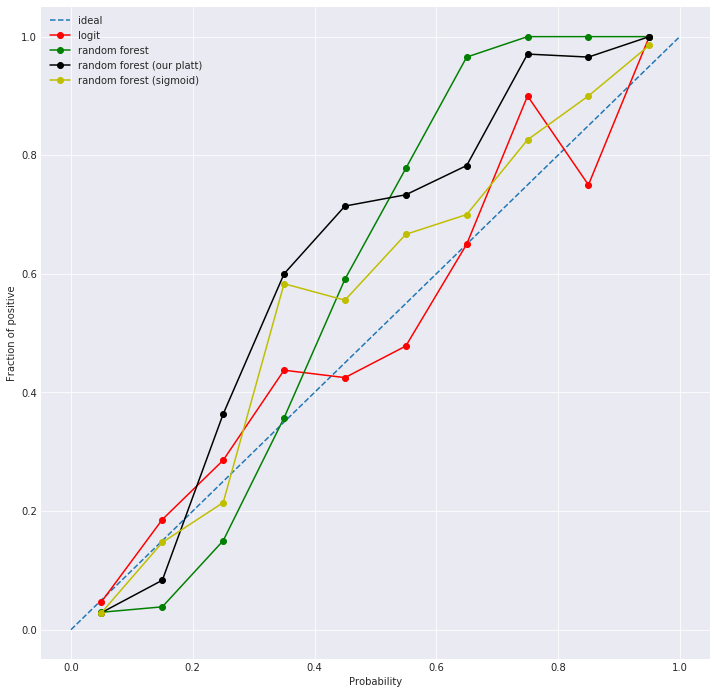

logit roc-auc score: 0.809298
random forest with sigmoid callibration roc-auc score: 0.912954


In [26]:
ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
forest_curve_platt = calibration_curve(probs_forest_platt, y_test)
plt.plot(forest_curve_platt[:,0], forest_curve_platt[:,1], 'o-',color='k')
forest_curve_platt_calibrator = calibration_curve(probs_forest_platt_calibrator, y_test)
plt.plot(forest_curve_platt_calibrator[:,0], forest_curve_platt_calibrator[:,1], 'o-',color='y')
plt.legend(['ideal', 'logit', 'random forest', 'random forest (our platt)', 'random forest (sigmoid)'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

print('logit roc-auc score: %f' % roc_auc_score(y_test,probs_logit))
print('random forest with sigmoid callibration roc-auc score: %f' % roc_auc_score(y_test,probs_forest_platt_calibrator))

Тут мы должны извлечь еще один урок: не стоит реализовать то, что уже реализовано кем-то =). Но желтая кривая уже выглядит заметно лучше зеленой.

# Isotonic regression

Начнем сразу с примера

In [27]:
X_train_iso, X_valid_iso, y_train_iso, y_valid_iso = train_test_split(X_train,y_train, test_size=0.3,shuffle=True, random_state=4444)
random_forest.fit(X_train_iso, y_train_iso)
calibrator = CalibratedClassifierCV(base_estimator=random_forest, method='isotonic', cv='prefit')
calibrator.fit(X_valid_iso,y_valid_iso)
probs_forest_iso_calibrator = calibrator.predict_proba(X_test)[:,1]

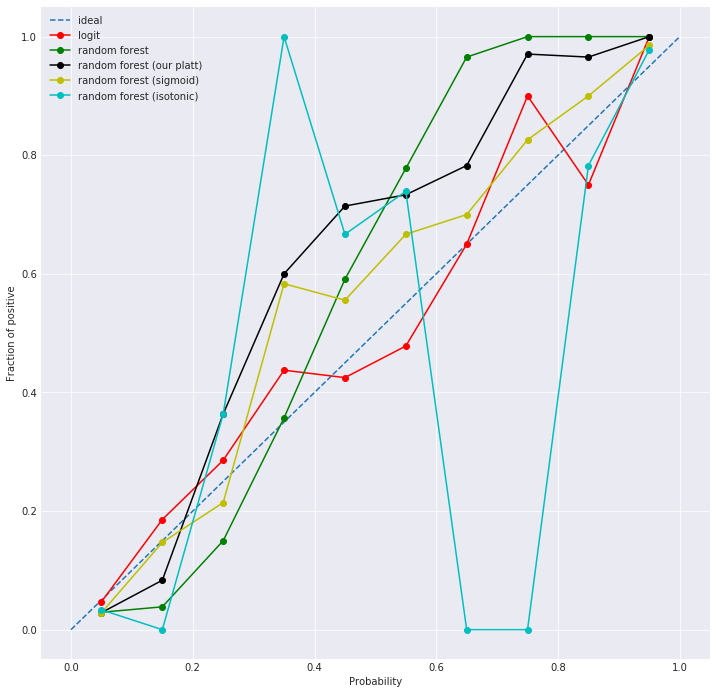

logit roc-auc score: 0.809298
random forest with isotonic callibration roc-auc score: 0.912954


In [28]:
ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
forest_curve_platt = calibration_curve(probs_forest_platt, y_test)
plt.plot(forest_curve_platt[:,0], forest_curve_platt[:,1], 'o-',color='k')
forest_curve_platt_calibrator = calibration_curve(probs_forest_platt_calibrator, y_test)
plt.plot(forest_curve_platt_calibrator[:,0], forest_curve_platt_calibrator[:,1], 'o-',color='y')
forest_curve_iso_calibrator = calibration_curve(probs_forest_iso_calibrator, y_test)
plt.plot(forest_curve_iso_calibrator[:,0], forest_curve_iso_calibrator[:,1], 'o-',color='c')
plt.legend(['ideal', 'logit', 'random forest', 'random forest (our platt)', 'random forest (sigmoid)', 'random forest (isotonic)'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

print('logit roc-auc score: %f' % roc_auc_score(y_test,probs_logit))
print('random forest with isotonic callibration roc-auc score: %f' % roc_auc_score(y_test,probs_forest_platt_calibrator))

Тут видна одна маленькая особенность изотонической регрессии: если данных мало, она переобучается. В документации приводится цифра <<1000, у нас же объектов было 700. Но всё таки, что же это такое "изотоническая регрессия"? На просторах интернета есть замечательная картинка:

<center>
<img src="../../img/isotonic_example.png">

Изотоническая регрессия стремится аппроксимировать данные с помощью не одной линии, а нескольких, но при этом они должны образовывать неубывающую функцию. Очевидно, что данный тип регрессии, в общем случае, сможет подстроиться под данные лучше, чем обычная. Всё упирается в сложность. <a href="http://stat.wikia.com/wiki/Isotonic_regression#Pool_Adjacent_Violators_Algorithm">Утверждается</a>, что в общем случае сложность обучения составляет порядка $n^4$, где $n$ - число объектов. Однако в нашем случае базовый алгоритм (случайный лес) хорошо ранжирует объекты, хоть и с неправильными вероятностями. Если $x_i, x_j$ - это вероятности для двух объектов с точки зрения случайного леса, а $y_i, y_j$ - реальные вероятности, можно смело утверждать, что если $x_i < x_j$, то и $y_i < y_j$. А если реальные вероятности отранжированны, есть простой <a href="http://stat.wikia.com/wiki/Isotonic_regression#Pool_Adjacent_Violators_Algorithm">алгоритм</a>, который обучается за линейной время.

Дабы всё таки убедиться, что изотоническая регрессия работает, рассмотрим dataset из десятого домашнего задания: предсказание задержки авиарейса.

In [29]:
# код частично сворован из 10ого дз
train = pd.read_csv('../../data/flight_delays_train.csv')
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_part, X_test, y_train_part, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_test = scaler.transform(X_test)
# обучаем логистическую регрессию
logit.fit(X_train_part, y_train_part)
probs_logit = logit.predict_proba(X_test)[:, 1]
# обучаем случайный лес
random_forest.fit(X_train_part, y_train_part)
probs_forest = random_forest.predict_proba(X_test)[:, 1]

# делаем отложенную выборку для калибровки
X_train_calibr, X_valid_calibr, y_train_calibr, y_valid_calibr = train_test_split(X_train_part,y_train_part, test_size=0.3,shuffle=True, random_state=4444)
#platt scaling
random_forest.fit(X_train_calibr, y_train_calibr)
calibrator = CalibratedClassifierCV(base_estimator=random_forest, method='sigmoid', cv='prefit')
calibrator.fit(X_valid_calibr,y_valid_calibr)
probs_forest_platt_calibrator = calibrator.predict_proba(X_test)[:,1]
# isotonic regression
calibrator = CalibratedClassifierCV(base_estimator=random_forest, method='isotonic', cv='prefit')
calibrator.fit(X_valid_calibr,y_valid_calibr)
probs_forest_iso_calibrator = calibrator.predict_proba(X_test)[:,1]

/home/cid/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


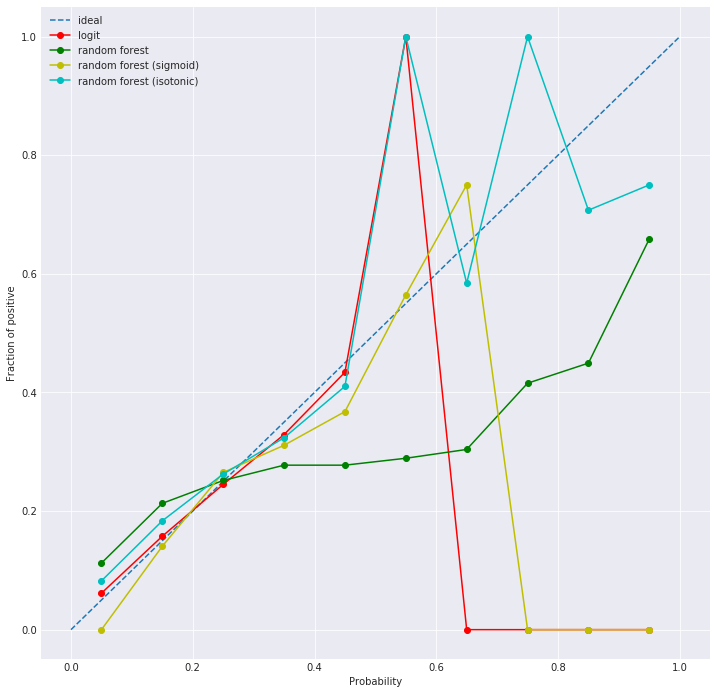

In [30]:
ideal_curve = np.linspace(0,1,21)
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(ideal_curve, ideal_curve, '--')

logit_curve = calibration_curve(probs_logit, y_test)
plt.plot(logit_curve[:,0], logit_curve[:,1], 'o-',color='r')
forest_curve = calibration_curve(probs_forest, y_test)
plt.plot(forest_curve[:,0], forest_curve[:,1], 'o-',color='g')
forest_curve_platt_calibrator = calibration_curve(probs_forest_platt_calibrator, y_test)
plt.plot(forest_curve_platt_calibrator[:,0], forest_curve_platt_calibrator[:,1], 'o-',color='y')
forest_curve_iso_calibrator = calibration_curve(probs_forest_iso_calibrator, y_test)
plt.plot(forest_curve_iso_calibrator[:,0], forest_curve_iso_calibrator[:,1], 'o-',color='c')
plt.legend(['ideal', 'logit', 'random forest', 'random forest (sigmoid)', 'random forest (isotonic)'])
plt.xlabel('Probability')
plt.ylabel('Fraction of positive')
plt.show()

In [31]:
print('logit roc-auc score: %f' % roc_auc_score(y_test,probs_logit))
print('random forest roc-auc score: %f' % roc_auc_score(y_test,probs_forest))
print('random forest with platt scaling roc-auc score: %f' % roc_auc_score(y_test,probs_forest_platt_calibrator))
print('random forest with isotonic callibration roc-auc score: %f' % roc_auc_score(y_test,probs_forest_iso_calibrator))

logit roc-auc score: 0.679569
random forest roc-auc score: 0.678175
random forest with platt scaling roc-auc score: 0.670712
random forest with isotonic callibration roc-auc score: 0.669182


Все рассмотренные модели имеют схожее качество, однако применение изотонической регрессии позволило лучше всего приблизить вероятности к идеальной прямой. 

# Заключение 

Сегодня мы узнали (а может, дорогой читатель, ты уже это знал), что predict_proba не всегда возвращает честные вероятности. Однако существует два метода, которые позволяют приблизить ответы модели к честным вероятностям. Platt's scaling прост и работает в любой ситуации, в то время как изотоническая регрессия имеет свойство переобучаться на малом количестве данных. Но если данных достаточно, предпочтительным является использование именно изотонической регрессии. В данном тьюториале основной упор был сделан на практику, потому что есть множество статей, которые в деталях описывают, как эти методы работают:

- википедия (<a href="https://en.wikipedia.org/wiki/Isotonic_regression"> изотоническая регрессия </a> и <a href="https://en.wikipedia.org/wiki/Platt_scaling">Platt's scaling </a>)
- еще одна <a href="http://stat.wikia.com/wiki/Isotonic_regression">вики</a> с подробным описанием алгоритма оптимизации изотонической регрессии
- Статья Платта <a href='http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639'>Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods</a>. Сам метод там описан хорошо
-  <a href="http://scikit-learn.org/stable/modules/calibration.html">Страница</a>, посвященная калибровке вероятностей на sklearn. Очень много хороших картинок, которые я тут уже дублировать не стал.